COMS 4731 Computer Vision -- Homework 3
==========

- In this homework, you will construct a panorama by stitching several individual and overlapping images together.
    - **Problem 1: Homography (20 points)**
        - Implement the `compute_homography` function.
        - Implement the `apply_homography` function.
    - **Problem 2: Warping (20 points)**
        - Implement the `backward_warp_img` function.
    - **Problem 3: SIFT and RANSAC (20 points)**
        - Implement the `RANSAC` function.
    - **Problem 4: Image Blending (20 points)**
        - Implement the `blend_image_pair` function.
    - **Problem 5: Creating Panoramas (20 points)**
        - Implement the `stitch_img` function.
        - Create a panorama using your own photos. 

- Your job is to implement the sections marked with TODO to complete the tasks.

- Submission 
    - Please submit the notebook (ipynb and pdf) including the output of all cells.

- Note: Please install OpenCV (version 3.4.2.16) by running the following command in the terminal
    - `pip install opencv-python==3.4.2.16; pip install opencv-contrib-python==3.4.2.16`
    - Otherwise, you may encounter error when running SIFT.
    


Setup
-----

Before we get started, let's visualize the three separate images we ultimately want to stitch together. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
import sys
import random
import cv2
%matplotlib inline




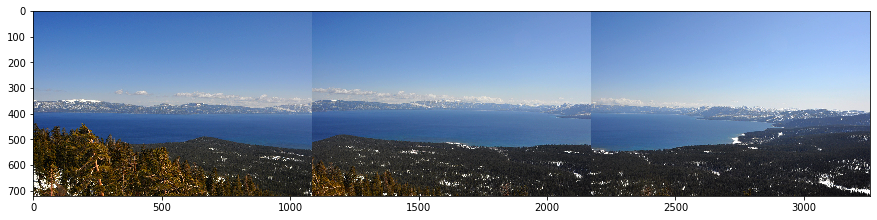

In [2]:
plt.rcParams['figure.figsize'] = [15, 15]

def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32")/255.
    return img

def show_image(img):
    plt.imshow(img, interpolation='nearest')
    
center_img = load_image("mountain_center.png")
left_img   = load_image("mountain_left.png")
right_img  = load_image("mountain_right.png")

show_image(np.concatenate([left_img, center_img, right_img], axis=1))

Problem 1: Homography
=========

You should finish implementing two functions below:

1. **compute_homography(src, dst)** receives two matrices of points, which are each Nx2. The function should return the homography matrix H that maps points from the source to the target. This return value should be a 3x3 matrix. We have given you most of the solution already. You just need to implement the A matrix.

2. **apply_homography(src, H)** receives points src (Nx2 matrix) and the homography transformation H (3x3 matrix). This function should use the homography matrix to transform src into the destination. Remember that you need to implement this using homogenous coordinates.

In [3]:
def compute_homography(src, dst):
    '''Computes the homography from src to dst.
    
    Input:
        src: source points, shape (n, 2)
        dst: destination points, shape (n, 2)
    Output:
        H: homography from source points to destination points, shape (3, 3)
        
    TODO: Implement the A matrix. 
    '''
    
    A = np.zeros([2*src.shape[0], 9])
    # Your code here.
    # temp array1: size: 2n * 3, every rows is [xi,yi,1]: points in src
    temp_array1 = np.ones([2*src.shape[0], 3])
    temp_array1[0:2*src.shape[0]:2, 0:2] = src[:,:]
    temp_array1[1:2*src.shape[0]:2, 0:2] = src[:,:]
    
    #print("temp_array1  ", temp_array1)
        
    # temp array2: size 2n*1, like [[-x0'],[-y0'],[-x1'],[-y'],......], these from dst 
    temp_array2 = np.zeros([2*dst.shape[0], 1])
    
    temp_array2[0:2*dst.shape[0]:2,:] = dst[:,0]
    temp_array2[1:2*dst.shape[0]:2,:] = dst[:,1]
    
    #print("temp_array2   ", temp_array2)
    
    # Combine
    A[0:A.shape[0]:2,0:2] = src
    A[1:A.shape[0]:2,3:5] = src
    
    A[0:A.shape[0]:2,2] = 1
    A[1:A.shape[0]:2,5] = 1
    
    A[:,6:9] = - temp_array2 * temp_array1
    
    
    w, v = np.linalg.eig(np.dot(A.T, A))
    index = np.argmin(w)
    H = v[:, index].reshape([3,3])
    return H
    

def apply_homography(src, H):
    '''Applies a homography H onto the source points.
    
    Input:
        src: source points, shape (n, 2)
        H: homography from source points to destination points, shape (3, 3)
    Output:
        dst: destination points, shape (n, 2)
    
    TODO: Implement the apply_homography function
    '''
    #implement this using homogenous coordinates.
    src_h = np.ones([src.shape[0], 3])
    src_h[:,0:2] = src
    
    # return value dst
    dst = np.zeros([src.shape[0],2])
    dst_h_t = np.dot(H, np.transpose(src_h))
    dst_h = np.transpose(dst_h_t)
    dst[:,0] = dst_h[:,0] / dst_h[:,2]
    dst[:,1] = dst_h[:,1] / dst_h[:,2]
    
    return dst

To help you debug the homography code, we have provided a test below. This uses pairs of points (src_pts and dst_pts) to compute the homography. Then, it applies the homography on held-out points (test_pts), and visualizes the correspondence as red lines between the two images. If you have correctly implemented compute_homography() and apply_homography, the red lines should connect the same points in both images.

Your solution differs from our solution by: 0.000000
If your solution is correct, the red lines will match to the same points in both images below:
If your solution is correct, the red lines will match to the same points in both images below:


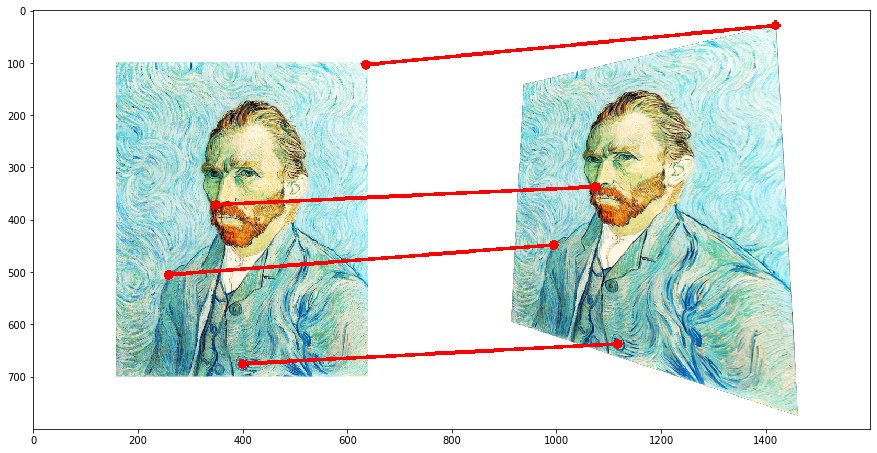

In [4]:
def test_homography():
    src_img = load_image('portrait.png')[:, :, :3]
    dst_img = load_image('portrait_transformed.png')
    whole_img = np.concatenate((src_img, dst_img), axis=1)

    src_pts = np.matrix('347, 313; 502, 341; 386, 571; 621, 508')
    dst_pts = np.matrix('274, 286; 436, 305; 305, 527; 615, 506')
    H = compute_homography(src_pts, dst_pts)

    test_pts = np.matrix('259, 505; 350, 371; 400, 675; 636, 104')
    match_pts = apply_homography(test_pts, H)

    match_pts_correct = np.matrix('195.13761083, 448.12645033;'
                                  '275.27269386, 336.54819916;'
                                  '317.37663747, 636.78403426;'
                                  '618.50438823, 28.78963905')

    print('Your solution differs from our solution by: %f'
          % np.square(match_pts - match_pts_correct).sum())
    for i in range(1):
        test_x = test_pts[i, 0]
        test_y = test_pts[i, 1]
        match_x = int(round(match_pts[i, 0] + 800))
        match_y = int(round(match_pts[i, 1]))

        cv2.line(whole_img,
            (test_x, test_y), 
            (match_x, match_y), 
            (255, 0, 0), thickness=5)
        cv2.circle(whole_img,
            (test_x, test_y),
            4, (255, 0, 0), thickness=10)
        cv2.circle(whole_img,
            (match_x, match_y),
            4, (255, 0, 0), thickness=10)

    print('If your solution is correct, the red lines will match to the same points in both images below:')
    show_image(np.clip(whole_img, 0, 1)) 
    
    for i in range(test_pts.shape[0]):
        test_x = test_pts[i, 0]
        test_y = test_pts[i, 1]
        match_x = int(round(match_pts[i, 0] + 800))
        match_y = int(round(match_pts[i, 1]))

        cv2.line(whole_img,
            (test_x, test_y), 
            (match_x, match_y), 
            (255, 0, 0), thickness=5)
        cv2.circle(whole_img,
            (test_x, test_y),
            4, (255, 0, 0), thickness=10)
        cv2.circle(whole_img,
            (match_x, match_y),
            4, (255, 0, 0), thickness=10)

    print('If your solution is correct, the red lines will match to the same points in both images below:')
    show_image(np.clip(whole_img, 0, 1)) 
    
test_homography()

Problem 2: Warping
=====

When we map a source image to its destination image using a homography, we may encounter a problem where multiple pixels of the source image are mapped to the same point of its destination image. What's more, some pixels of the destination image may not be mapped to any pixels of source image. What should we do?

Suppose we had homography $H$, source pixel $s$ with coordinates $(x_s, y_s)$, and destination pixel $d$ with coordinates $(x_d, y_d)$. Then, $H \cdot \tilde{s} = \tilde{d}$ (where, $s$, $d$ are in homogenous space).

To deal with this problem, we warp in the opposite direction: we map the pixels of the destination image back to source image, and then use the color in the source image as its color. More precisely, for each destination pixel $d = (x_d, y_d)$, we take $H^{-1} \cdot \tilde{d}$ to obtain the coordinate of its associated source pixel, $\tilde{s}$ (from which $s$ can be found). If $s$ is within the bounds of the source image, we take the intensity of $s$ to be the intensity of $d$.

Repeating this process over the entire destination image ensures that there are no gaps in the final result. This process is called "backward warping".


In [5]:
def backward_warp_img(src_img, H, dst_img_size):
    '''Backward warping of the source image using a homography.
    
    Input:
        src_img: source image, shape (m, n, 3)
        H: homography from destination to source image, shape (3, 3)
        dst_img_size: height and width of destination image, shape (2,)
    Output:
        dst_img: destination image, shape (m, n, 3)
    
    TODO: Implement the backward_warp_img function. 
    '''
    num_row = 0
    num_column = 0
    
    # dst_y
    
    # newest
    dst_img = np.zeros([dst_img_size[0], dst_img_size[1],3])
    for num_row in range(dst_img_size[0]):
        for num_column in range(dst_img_size[1]):
            temp_d = np.array([[num_column],[num_row],[1]])
            temp_s = np.dot(H,temp_d)
            temp_s[0][0] = (temp_s[0][0] / temp_s[2][0])
            temp_s[1][0] = (temp_s[1][0] / temp_s[2][0])
            x = int(temp_s[0][0])
            y = int(temp_s[1][0])
           
            #print("num_column: ",num_column,"   x:  ",x)
            #print("num_row:  ",num_row,"   y:  ",y)
            #print("w:  ",temp_s[0][0])
            if x >= 0 and x < src_img.shape[1]:
                if y >= 0 and y < src_img.shape[0]:
                    dst_img[num_row][num_column] = src_img[y][x]
            
    return dst_img
    

def binary_mask(img):
    '''Create a binary mask of the image content.
    
    Input:
        img: source image, shape (m, n, 3)
    Output:
        mask: image of shape (m, n) and type 'int'. For pixel [i, j] of mask, if img[i, j] > 0 
              in any of its channels, mask[i, j] = 1. Else, (if img[i, j] = 0), mask[i, j] = 0.
    '''
    
    mask = (img[:, :, 0] > 0) | (img[:, :, 1] > 0) | (img[:, :, 2] > 0)
    mask = mask.astype("int")
    
    return mask

Use the function below to help debug your implementation. If it is correct, it should warp Van Gogh's self-portrait onto the building side.

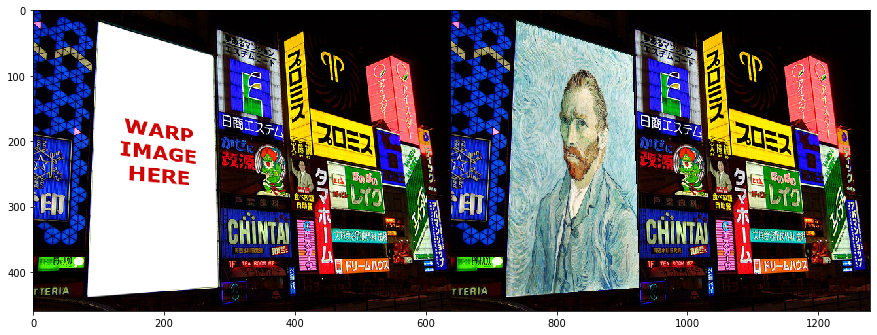

In [6]:
def test_warp():
    src_img = load_image('portrait_small.png')
    canvas = load_image('Osaka.png')

    src_pts = np.matrix('1, 1; 1, 400; 326, 1; 326, 400')
    canvas_pts = np.matrix('100, 18; 84, 437; 276, 71; 286, 424')
    H = compute_homography(src_pts, canvas_pts)

    dst_img = backward_warp_img(src_img, np.linalg.inv(H), [canvas.shape[0], canvas.shape[1]])
    dst_mask = 1 - binary_mask(dst_img)
    dst_mask = np.stack((dst_mask,) * 3, -1)
    out_img = np.multiply(canvas, dst_mask) + dst_img

    warp_img = np.concatenate((canvas, out_img), axis=1)

    show_image(np.clip(warp_img, 0, 1))
    
test_warp()

Problem 3: SIFT and RANSAC
====

SIFT Keypoints
--------------

So far, we have manually defined corresponding keypoints for both estimating homographies and warping. We want to automate this now. However, if we just take two photos, how do we know which points correspond? We could estimate SIFT keypoints, and take the nearest neighbor between them. The code below computes SIFT keypoints, and visualizes the matches.

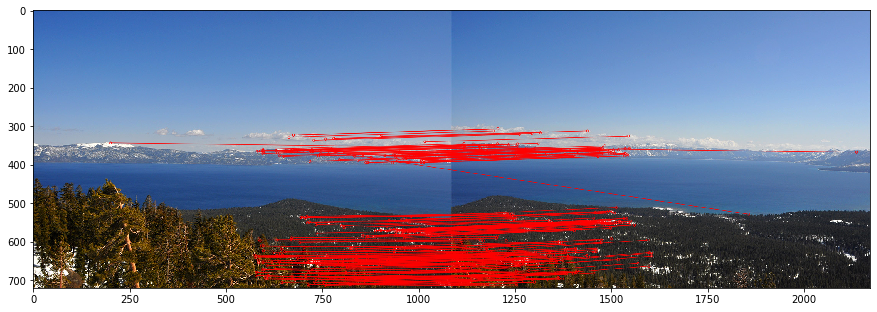

In [7]:
def genSIFTMatchPairs(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    pts1 = np.zeros((250,2))
    pts2 = np.zeros((250,2))
    for i in range(250):
        pts1[i,:] = kp1[matches[i].queryIdx].pt
        pts2[i,:] = kp2[matches[i].trainIdx].pt
    
    return pts1, pts2, matches[:250], kp1, kp2

def test_matches():
    img1 = cv2.imread('mountain_left.png')
    img2 = cv2.imread('mountain_center.png')

    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)

    matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2, matchColor=(0,0,255))
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

test_matches()

In [8]:
img1 = cv2.imread('mountain_left.png')
img2 = cv2.imread('mountain_center.png')

pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)

RANSAC
------
Instead, we will use RANSAC, which is an optimization algorithm that finds correspondences while also discarding the outliers. Implement the RANSAC function below.

In [9]:
import math
def RANSAC(Xs, Xd, max_iter, eps):
    '''Finds correspondences between two sets of points using the RANSAC algorithm.
    
    Input:
        Xs: the first set of points (source), shape [n, 2]
        Xd: the second set of points (destination) matched to the first set, shape [n, 2]
        max_iter: max iteration number of RANSAC
        eps: tolerance of RANSAC
    Output:
        inliers_id: the indices of matched pairs when using the homography given by RANSAC
        H: the homography, shape [3, 3]
    
    TODO: Implement the RANSAC function. 
    '''
    # ed
    num_match = Xs.shape[0]
    # the count number of iteration
    i = 0
    # the count of number of indices of 
    j = 0
    inliers_id = []
    
    for i in range(0,max_iter):
        # randomly select 4 matched points
        sample_set = random.sample(range(0, num_match), 4)
        src_sample = np.matrix(Xs[sample_set])
        dst_sample = np.matrix(Xd[sample_set])
        H_sample = compute_homography(src_sample, dst_sample)
        
        temp_inliers_id = []
        match_pts = apply_homography(Xs, H_sample)
        # caculate the euclidean distances between transformed destination points and given destination points
        temp = np.sum(pow((match_pts - Xd),2), axis=1)
        euc_dst =  np.sqrt(temp)
        
        j = 0
        for j in range(Xd.shape[0]):
            if euc_dst[j] < eps:
                temp_inliers_id.append(j)
        
        if len(temp_inliers_id) > len(inliers_id):
            inliers_id = temp_inliers_id
            H = H_sample
    return inliers_id, H    
    

Now, let's visualize the matches between keypoints after using your RANSAC implementation. If you implemented RANSAC correctly, the outlier matches should be automatically discarded.

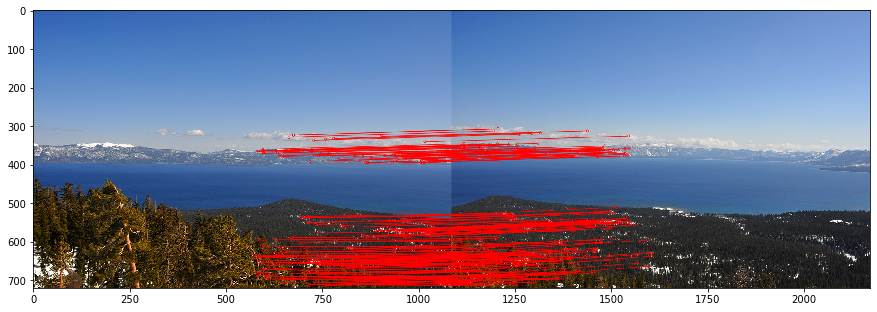

In [10]:
def test_ransac():
    img1 = cv2.imread('mountain_left.png')
    img2 = cv2.imread('mountain_center.png')

    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)
    
    inliers_idx, H = RANSAC(pts1, pts2, 500, 20)

    new_matches = []
    for i in range(len(inliers_idx)):
        new_matches.append(matches[inliers_idx[i]])

    matching_result = cv2.drawMatches(img1, kp1, img2, kp2, new_matches, None, flags=2, matchColor=(0,0,255))
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))
    
test_ransac()



Problem 4: Image Blending
====

We have now implemented code to estimate correspondences between photos, estimate the homography, and warp one image into the other image. Before we can build our panorama making application, the next piece we need is code to seamlessly blend two images together.

In [11]:
from scipy.ndimage.morphology import distance_transform_edt as euc_dist

def blend_image_pair(src_img, src_mask, dst_img, dst_mask, mode):
    '''Given two images and their binary masks, blend the two images.
    
    Input:
        src_img: First image to be blended, shape (m, n, 3)
        src_mask: src_img's binary mask, shape (m, n)
        dst_img: Second image to be blended, shape (m, n, 3)
        dst_mask: dst_img's binary mask, shape (m, n)
        mode: Blending mode, either "overlay" or "blend"
    Output:
        Blended image of shape (m, n, 3)
    
    TODO: Implement the blend_image_pair function.
    '''
    
    if mode == "overlay":
        m_temp = src_mask - dst_mask
        m_src_new = m_temp > 0
        m_src_new = m_src_new.astype("int")
        
        src_final = np.zeros([src_img.shape[0],src_img.shape[1],3])
        
        src_final[:,:,0] = m_src_new * src_img[:,:,0]
        src_final[:,:,1] = m_src_new * src_img[:,:,1]
        src_final[:,:,2] = m_src_new * src_img[:,:,2]
        
        
        overlay_image = src_final + dst_img
        
        return overlay_image
    
    # alpha blending
    if mode == "blend":
        m_temp2 = np.zeros([src_mask.shape[0], src_mask.shape[1]])
        m_temp2[:,:] = src_mask[:,:] + dst_mask[:,:]
        m_temp2 = (m_temp2 > 0)
        m_temp2.astype("int")
        
        sum_over_rows = np.sum(m_temp2, axis=1)
        alpha = np.zeros([m_temp2.shape[0], m_temp2.shape[1]])
        alpha[:,:] = m_temp2[:,:]
        

        i = 0
        for i in range(m_temp2.shape[1]):
            alpha[:,i] = alpha[:,i] / sum_over_rows
            if i > 1:
                alpha[:,i] = alpha[:,i-1] + alpha[:,i]
        
        # alpha: increasing with the increase of the column number range(0 - 1)
        f_alpha = np.zeros([src_img.shape[0],src_img.shape[1],3])
        f_alpha[:,:,0] = src_img[:,:,0] * (1 - alpha)
        f_alpha[:,:,1] = src_img[:,:,1] * (1 - alpha)
        f_alpha[:,:,2] = src_img[:,:,2] * (1 - alpha)

        h_alpha = np.zeros([dst_img.shape[0], dst_img.shape[1],3])
        h_alpha[:,:,0] = dst_img[:,:,0] * alpha
        h_alpha[:,:,1] = dst_img[:,:,1] * alpha
        h_alpha[:,:,2] = dst_img[:,:,2] * alpha
        
        blend_image = f_alpha + h_alpha
        
        return blend_image
    
            

To test your implementation, you can use the function below. It supports two modes. Setting mode="blend" should seamlessly blend the two images. Setting mode="overlay" will just combine them without any blending.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


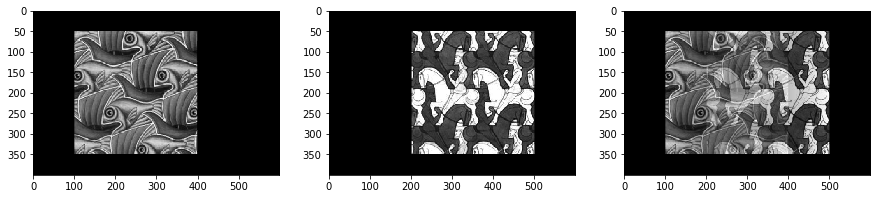

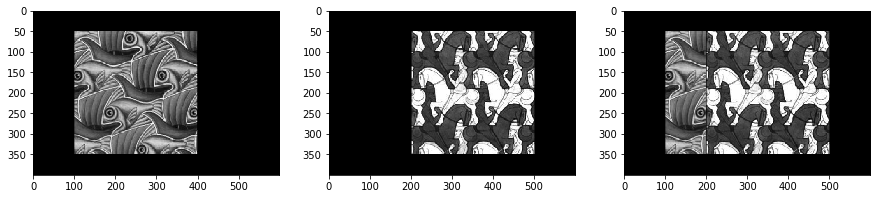

In [12]:
def test_blend(mode):
    fish_img = load_image("escher_fish.png")[:, :, :3]
    horse_img = load_image("escher_horsemen.png")[:, :, :3]

    blend_img = blend_image_pair(fish_img, binary_mask(fish_img), horse_img, binary_mask(horse_img), mode)

    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(fish_img, cmap='gray')
    axarr[1].imshow(horse_img, cmap='gray')
    axarr[2].imshow(blend_img,cmap='gray')
    
test_blend("blend")
test_blend("overlay")

Problem 5: Creating Panoramas
====

We are now ready to make a panorama from the three images at the beginning. The function below receives a Python list of images, which you should stitch together to form one large image. You will need to call most of the functions defined above in order to successfully do this. 

To receive full credit, make sure you have stitched the three images together with very little seam between them. 

In [23]:
def stitch_img(imgs):
    '''Stitch a list of images together.
    
    Input: 
        imgs: a list of images.
    Output:
        stitched_img: a single stiched image.
        
    TODO: implement the stitch_img function. 
    '''
    left_img = imgs[1]
    center_img = imgs[0]
    right_img = imgs[2]
    
    
    #img0 = cv2.imread('mountain_left.png')
    #img1 = cv2.imread('mountain_center.png')
    img1 = left_img
    img0 = center_img

    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img0, img1)
    
    inliers_idx, H = RANSAC(pts1, pts2, 500, 20)

    new_matches = []
    for i in range(len(inliers_idx)):
        new_matches.append(matches[inliers_idx[i]])
    
    matching_result = cv2.drawMatches(img0, kp1, img1, kp2, new_matches, None, flags=2, matchColor=(0,0,255))
    #plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))
    
    result = cv2.warpPerspective(img0, H, (img0.shape[1] + img1.shape[1], img0.shape[0])) 
    result[0:img1.shape[0], 0:img1.shape[1]] = img1
    #plt.imshow(cv2.cvtColor(result.astype("uint8"), cv2.COLOR_BGR2RGB));
    
    
   
    
    # add another picture
    #img3 = cv2.imread('mountain_center.png')
    #img2 = cv2.imread('mountain_right.png')
    
    img2 = center_img
    img3 = right_img

    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img3, img2)
    
    inliers_idx, H = RANSAC(pts1, pts2, 500, 20)

    new_matches = []
    for i in range(len(inliers_idx)):
        new_matches.append(matches[inliers_idx[i]])

    #matching_result = cv2.drawMatches(img3, kp1, img2, kp2, new_matches, None, flags=2, matchColor=(0,0,255))
    #plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))
    
    result2 = cv2.warpPerspective(img3, H, (img3.shape[1] + img2.shape[1], img3.shape[0])) 
    result2[0:img2.shape[0], 0:img2.shape[1]] = img2
    #plt.imshow(cv2.cvtColor(result2.astype("uint8"), cv2.COLOR_BGR2RGB));
    
    
    #adding together
    #img2 = result
    #img3 = result2
    
    '''
    final = result
    final2 = result2
    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(final2, result)
    
    inliers_idx, H = RANSAC(pts1, pts2, 500, 20)

    new_matches = []
    for i in range(len(inliers_idx)):
        new_matches.append(matches[inliers_idx[i]])
    
    matching_result = cv2.drawMatches(final2, kp1, final, kp2, new_matches, None, flags=2, matchColor=(0,0,255))
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))
    
    result3 = cv2.warpPerspective(final2, H, (final2.shape[1] + final.shape[1], final.shape[0])) 
    #result3[0:result.shape[0], 0:result.shape[1]] = result
    plt.imshow(cv2.cvtColor(result3.astype("uint8"), cv2.COLOR_BGR2RGB));
    '''
    
    # method 2 add the method together
    #final image  = 
    
    mask_left_center = binary_mask(result)
    i = 0
    for i in range(result.shape[1]):
        if mask_left_center[0][i] == 0:
            break
    
    j = 0
    temp= result.shape[0] - 20 
    for j in range(result.shape[1]):
        if mask_left_center[temp][j] == 1 and mask_left_center[temp][j+1] == 0:
            break
    average = int((i+j) /2)
    
    final = np.zeros([result.shape[0], result.shape[1] + right_img.shape[1] ,3])
    final_right = np.zeros([right_img.shape[0], right_img.shape[1],3])
    final_right[:,:,:] = result2[:, center_img.shape[1]:,:]
    
    final[:, 0:result.shape[1],:] = result[:,:,:]
    #final[:,average:average+final_right.shape[1],:] = final_right[:,0:,:]
    final[:,i:i+final_right.shape[1],:] = final_right[:,0:,:]
    return result, result2 , final
    

Use the below code to test your implementation. This code just reads in the images, calls the stitch_img() function, and plots the results.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ComplexWarning: Casting complex values to real discards the imaginary part
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


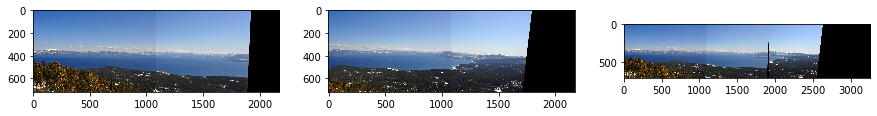

In [24]:
center_img = cv2.imread("mountain_center.png")
left_img = cv2.imread("mountain_left.png")
right_img = cv2.imread("mountain_right.png")
left_center, center_right, final_img = stitch_img([center_img, left_img, right_img])
#plt.imshow(cv2.cvtColor(final_img.astype("uint8"), cv2.COLOR_BGR2RGB));

f, axarr = plt.subplots(1,3)
axarr[0].imshow(cv2.cvtColor(left_center.astype("uint8"), cv2.COLOR_BGR2RGB));
axarr[1].imshow(cv2.cvtColor(center_right.astype("uint8"), cv2.COLOR_BGR2RGB));
axarr[2].imshow(cv2.cvtColor(final_img.astype("uint8"), cv2.COLOR_BGR2RGB));

Make Your Own Panarama
--- 

Use a digital camera, such as from your phone, and take three or more photos to create your own panaroma. Remember to be stand in place and only rotate the camera (Think about: why?). Include them in your submission, and we will show the best ones during lecture.

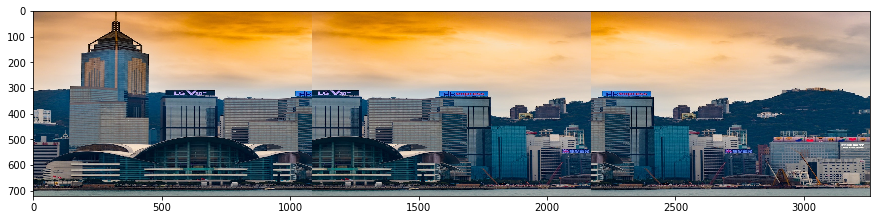

In [15]:
# present my own Panarama slices
center_img2 = cv2.imread("center.jpg")
left_img2   = cv2.imread("left.jpg")
right_img2  = cv2.imread("right.jpg")


imgs = np.concatenate([left_img2, center_img2, right_img2], axis=1)
plt.imshow(cv2.cvtColor(imgs.astype("uint8"), cv2.COLOR_BGR2RGB))


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ComplexWarning: Casting complex values to real discards the imaginary part
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


i:   1086
j:  1618


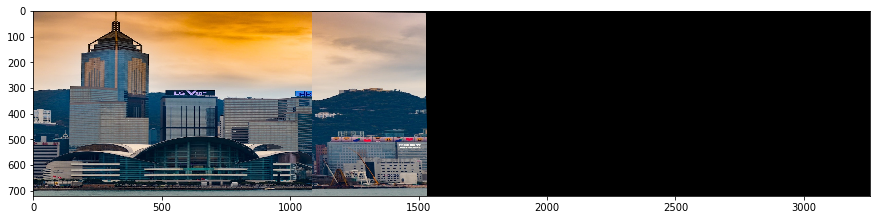

In [16]:
img_list = []  
''' 
TODO: Load your own images here and create a panorama. 
'''
img_list = [center_img2, left_img2, right_img2]

final_img2 = stitch_img(img_list)

plt.imshow(cv2.cvtColor(final_img2.astype("uint8"), cv2.COLOR_BGR2RGB));

